In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.fits as pyfits
from astropy import units as u
from scipy import interpolate
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr, spearmanr

In [2]:
dirs = ['7-20211101-20220619/']#,'6-20200915-20210503/','4-20180918-20190528/','3B-20180206-20180622/','8-20220818-20230223/','1-20150918-20160527/','2-20160913-20170615/','3A-20170919-20180123/','5-20190928-20200608/']
dirs.sort()
# dir = 'all-20150918-20230223/'
# dir = '8-20220818-20230223/'
# lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
# emin = 0.1 *u.GeV
# emax = 300 *u.GeV
# D_l = 1588.6 *u.Mpc
# hdul = fits.open('./' + dir+lc_file_path)
# lc = hdul[1].data

## OPTICAL R-BAND DATA

In [3]:
rmagdat = pd.read_csv('./apjlad4d9bt1_mrt.txt', sep='\s+', header=None, skiprows=25, names=['HJD', 'Rmag', 'e_Rmag', 'NPTS'])


#convert Rmag to flux

# m1 - m2 = -2.5 log10(f1/f2)
# m2 = 0; f2 = 3.08 * 10**-20 erg/cm^2/s

f2 = 3.08 * 10**-20 * (u.erg/u.cm**2/u.s)
f2 = f2.to(u.MeV/u.cm**2/u.d)

f1 = (10**(rmagdat['Rmag'].values + 2.5)) * f2
f1_err = (10**(rmagdat['e_Rmag'] + 2.5)) * f2


In [4]:
tt = rmagdat['HJD'].values - 2400000.5
idx = []
for i in range(len(tt)):
    if tt[i] <= 59800 and tt[i] >= 59500:
        idx.append(i)

/tmp/ipykernel_18663/1805507762.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
/tmp/ipykernel_18663/1805507762.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2, 11)


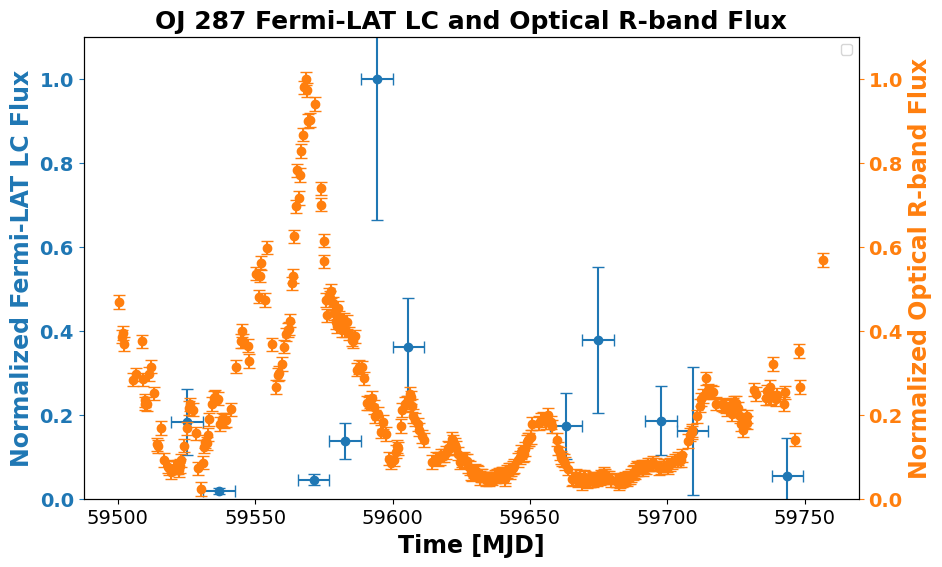

In [5]:
TSmin = 9

dir = dirs[0]
lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
emin = 0.1 *u.GeV
emax = 300 *u.GeV
D_l = 1588.6 *u.Mpc
hdul = fits.open('./' + dir+lc_file_path)
lc = hdul[1].data
if len(lc['flux']) > 0:
    scale = int(np.log10(lc['flux'].max())) -2
else:
    scale = int(np.log10(lc['flux_ul95'].max())) -2
    
tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2


# find the nearest element in x_rmag for each element in x_lc
lcx = np.argwhere(lc['ts'] > TSmin)
x_lc = tmean[lc['ts'] > 9]
xl_lc = lc['tmin_mjd'][lc['ts'] > 9]
xr_lc = lc['tmax_mjd'][lc['ts'] > 9]

print(np.shape([x_lc - xl_lc, xr_lc - x_lc]))

x_lc = np.array(tmean[lcx]).flatten()
xl_lc = np.array(lc['tmin_mjd'][lcx]).flatten()
xr_lc = np.array(lc['tmax_mjd'][lcx]).flatten()
y_lc = np.array(lc['flux'])[lcx]/max(lc['flux'][lcx]).flatten()
yerr_lc = np.array(lc['flux_err'])[lcx]/max(lc['flux'][lcx]).flatten()


y_lc = np.array(lc['flux'])[lc['ts'] > 9]/max(lc['flux'])
yerr_lc = np.array(lc['flux_err'])[lc['ts'] > 9]/max(lc['flux'] + max(lc['flux_err']))

x_rmag = np.subtract(rmagdat['HJD'], 2400000.5)
y_rmag = f1
y_err_rmag = f1_err
x_rmag_cb = x_rmag[idx[0]:idx[-1]]
y_rmag_cb = y_rmag[idx[0]:idx[-1]]
y_err_rmagb = y_err_rmag[idx[0]:idx[-1]]
idx = np.zeros(len(x_lc), dtype=int)
for i in range(len(x_lc)):
    idx[i] = np.abs(x_rmag - x_lc[i]).argmin()
   

x_rmag_c = x_rmag[idx]
y_rmag_c = y_rmag[idx]
y_err_rmag = y_err_rmag[idx]


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.xlabel('Time [MJD]', fontdict={'size': 17, 'weight': 'bold'})
plt.xticks(fontsize=14)
ax2 = ax.twinx()

ax.errorbar(x_lc, y_lc/max(y_lc), yerr=yerr_lc/max(y_lc), xerr=[x_lc - xl_lc, xr_lc - x_lc], c='C0', fmt='o', capsize=4, label='Fermi-LAT LC')
# ax.plot(x_lc, y_lc/max(y_lc), c='C0', lw=0.2)
ax.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
TSmin=9




ax2.errorbar(x_rmag_cb, y_rmag_cb/max(y_rmag_cb), yerr=y_err_rmagb/max(y_rmag_cb),  c='C1', fmt='o', capsize=4)
# ax2.errorbar(x_rmag_c, y_rmag_c/max(y_rmag_c), yerr=y_err_rmag/max(y_rmag_c),xerr=[tmean[lc['ts']>TSmin]- lc['tmin_mjd'][lc['ts']>TSmin], lc['tmax_mjd'][lc['ts']>TSmin] - tmean[lc['ts']>TSmin]], c='C2', fmt='o', capsize=4)

# ax2.vlines(59531.5, 0, 1.2, color='red', linestyle='--', label='Nov 12 2021')

# ax2.plot(x_rmag_c, y_rmag_c/max(y_rmag_c), c='C1', lw=0.2)
ax.set_ylabel('Normalized Fermi-LAT LC Flux', color='C0', fontdict={'size': 17, 'weight': 'bold'})
ax2.set_ylabel('Normalized Optical R-band Flux', color='C1', fontdict={'size': 17, 'weight': 'bold'})    
ax2.set_yticklabels(np.arange(0, 1.1, 0.2).round(2), fontdict={'size': 14, 'weight': 'bold'})
ax.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax.tick_params(axis='y', colors='C0', labelcolor='C0')
ax2.tick_params(axis='y', colors='C1', labelcolor='C1')

# ax2.set_xlabel('Time [MJD]')
# plt.xlabel('Time [MJD]')
ax2.legend()
plt.title('OJ 287 Fermi-LAT LC and Optical R-band Flux', fontdict={'size': 18, 'weight': 'bold'})
# plt.show()
plt.savefig('./temp/OJ287_LC_R_band.pdf', dpi=300, facecolor='w', edgecolor='w', format='pdf')

In [6]:
tmean[lcx].flatten()

array([59525.25075444, 59536.75075444, 59571.25075444, 59582.75075444,
       59594.25075444, 59605.75075444, 59663.25075444, 59674.75075444,
       59697.75075444, 59709.25075444, 59743.75075444])

In [7]:
print(np.round(pearsonr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)), 3))
print(np.round(spearmanr(y_lc/max(y_lc), y_rmag_c/max(y_rmag_c)), 3))

[-0.265  0.43 ]
[-0.645  0.032]


## SWIFT DATA

In [8]:
# swift_data = pd.read_csv('./Swift-OJ287.txt', sep='\t', skiprows=2)
swift_data = np.loadtxt('./Swift-OJ287.txt', skiprows=4, dtype=np.float64)
np.delete(swift_data, 99)
t_sw_mjd, flux_sw, flux_err_sw = swift_data.T
t_sw_mjd

array([57354.07111238, 57358.98139732, 57359.61735624, 57360.68615658,
       57361.47704158, 57362.27328116, 57363.24328718, 57364.33537228,
       57365.45492613, 57366.29450121, 57367.02961604, 57369.37460204,
       57370.42100503, 57371.29250863, 57377.8066174 , 57386.91335793,
       57388.78882128, 57390.41892739, 57392.48723768, 57394.27835496,
       57396.9498567 , 57397.7370774 , 57400.33337188, 57402.85687083,
       57404.09555962, 57406.06110199, 57408.40403115, 57429.75621434,
       57432.23760508, 57435.5246911 , 57441.64236531, 57444.26668283,
       57447.21046233, 57451.78302678, 57453.90627942, 57459.70546858,
       57462.11611969, 57464.01425481, 57468.90082317, 57471.95537672,
       57475.30869566, 57501.09963885, 57507.94263947, 57514.52310447,
       57522.96621841, 57528.01344364, 57535.25508527, 57546.4224682 ,
       57552.94134255, 57673.35660857, 57676.38028736, 57677.08010158,
       57678.40789699, 57679.56484706, 57680.78859343, 57681.22612005,
      

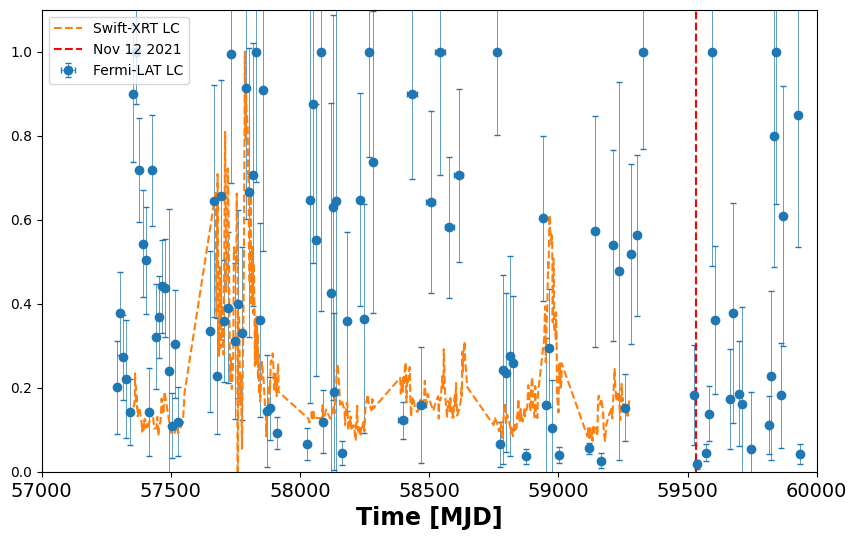

In [43]:
dirs = ['6-20200915-20210503/']
dir = dirs[0]
lc_file_path = 'Output/Light_curve_001/4fgl_j0854.8+2006_lightcurve.fits'
emin = 0.1 *u.GeV
emax = 300 *u.GeV
D_l = 1588.6 *u.Mpc


dirs = ['7-20211101-20220619/','6-20200915-20210503/','4-20180918-20190528/','3B-20180206-20180622/','8-20220818-20230223/','1-20150918-20160527/','2-20160913-20170615/','3A-20170919-20180123/','5-20190928-20200608/']
dirs.sort()


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plt.xlabel('Time [MJD]', fontdict={'size': 17, 'weight': 'bold'})
plt.xticks(fontsize=14)
plt.ylim(0, 1.1)
# ax.hlines(1, 57000, 60000)


# ax.errorbar(t_sw_mjd, flux_sw/max(flux_sw), yerr=flux_err_sw/max(flux_sw), c='C2', fmt=None, capsize=1.5, label='Swift-XRT LC')

x_fermi = []
y_fermi = []
xl_fermi = []
xr_fermi = []
yerr_fermi = []

for dir in dirs:
    hdul = fits.open('./' + dir+lc_file_path)
    lc = hdul[1].data
    if len(lc['flux']) > 0:
        scale = int(np.log10(lc['flux'].max())) -2
    else:
        scale = int(np.log10(lc['flux_ul95'].max())) -2
        
    tmean = (lc['tmin_mjd'] + lc['tmax_mjd'])/2


    # find the nearest element in x_rmag for each element in x_lc
    lcx = np.argwhere(lc['ts'] > TSmin)
    xl_lc = lc['tmin_mjd'][lc['ts'] > 9]
    xr_lc = lc['tmax_mjd'][lc['ts'] > 9]
    x_lc = np.array(tmean[lcx]).flatten()
    xl_lc = np.array(lc['tmin_mjd'][lcx]).flatten()
    xr_lc = np.array(lc['tmax_mjd'][lcx]).flatten()
    y_lc = np.array(lc['flux'])[lcx]/max(lc['flux'][lcx])
    yerr_lc = np.array(lc['flux_err'])[lcx]/max(lc['flux'][lcx])
    # yerr_lc = np.array(lc['flux_err'])[lc['ts'] > 9]/max(lc['flux'] + max(lc['flux_err']))
    y_lc = y_lc.flatten()
    yerr_lc = yerr_lc.flatten()
    x_fermi = np.append(x_fermi, x_lc)
    y_fermi = np.append(y_fermi, y_lc/max(y_lc))
    # xerr_fermi = np.append(xerr_fermi, [x_lc - xl_lc, xr_lc - x_lc])
    xl_fermi = np.append(xl_fermi, xl_lc)
    xr_fermi = np.append(xr_fermi, xr_lc)
    yerr_fermi = np.append(yerr_fermi, yerr_lc/max(y_lc))

    # y_lc = np.array(lc['flux'])[lc['ts'] > 9]/max(lc['flux'])
    
    # ax.errorbar(x_lc, y_lc/max(y_lc), fmt='o', yerr=yerr_lc/max(y_lc), xerr=[x_lc - xl_lc, xr_lc - x_lc], capsize=2, lw = 0.5, c = 'C0')

ax.errorbar(x_fermi, y_fermi, yerr=yerr_fermi, xerr=[x_fermi - xl_fermi, xr_fermi - x_fermi], fmt='o', capsize=2, lw=0.5, c='C0', label='Fermi-LAT LC')
ax.plot(t_sw_mjd, flux_sw/max(flux_sw), c='C1', lw=1.5, ls='--', label='Swift-XRT LC')
ax.vlines(59531.5, 0, 1.2, color='red', linestyle='--', label='Nov 12 2021')
# ax.plot(x_rmag, y_rmag/max(y_rmag), c='C1', lw=1.5, ls='--', label='Optical R-band LC')
ax.set_xlim(57000, 60000)
ax.legend()

In [35]:
idx1 = []

x_fermi_cb = []
y_fermi_cb = []
xl_fermi_cb = []
xr_fermi_cb = []

for i in range(len(x_fermi)):
    if x_fermi[i] <= max(t_sw_mjd) and x_fermi[i] >= min(t_sw_mjd):
        idx1.append(i)
        x_fermi_cb.append(x_fermi[i])
        y_fermi_cb.append(y_fermi[i])
        xl_fermi_cb.append(xl_fermi[i])
        xr_fermi_cb.append(xr_fermi[i])

In [37]:
idx = np.zeros(len(x_fermi_cb), dtype=int)
for i in range(len(x_fermi_cb)):
    
    idx[i] = np.abs(t_sw_mjd - x_fermi_cb[i]).argmin()

idx

array([  8,  14,  17,  23,  26,  27,  30,  34,  37,  40,  41,  41,  43,
        45,  49,  49,  52,  63,  73,  78,  85,  89,  95,  99, 106, 115,
       127, 137, 149, 152, 156, 162, 173, 176, 177, 181, 183, 185, 186,
       190, 191, 193, 195, 200, 204, 228, 235, 240, 244, 248, 260, 267,
       274, 280, 291, 305, 319, 322, 325, 327, 329, 332, 350, 363, 365,
       371, 377, 396, 410, 419, 426, 434, 439, 445])

In [38]:
x_sw_cb = t_sw_mjd[idx]
y_sw_cb = flux_sw[idx]
yerr_sw_cb = flux_err_sw[idx]

In [42]:
print(np.round(pearsonr(y_fermi_cb, y_sw_cb/max(y_sw_cb)), 3))
print(np.round(spearmanr(y_fermi_cb, y_sw_cb/max(y_sw_cb)), 3))

[0.093 0.43 ]
[0.177 0.132]
